## Predicting alcohol consumption in Moskow
### Authors: Mikołaj Szopa, Bartosz Trynda
The main objective of the project is to analyze and attempt to make a forecast of per capita alcohol consumption in 2017 based on data gathered \
between 1998 and 2016 in Russia. In addition, the aim is to check whether the GDP values can help to estiamte future cinsumption.

If the algorithm works fine it might be help for i.e. non-governmental organizations for preparing resources and create plans for \
campaigns against alcoholism and addiction.


### The data
The data used in this project comes mainly for kaggle webstite https://www.kaggle.com/datasets/dwdkills/alcohol-consumption-in-russia \
Data set contains values of consumption of different types of alcohols i.e. beer, vodka, wine etc. durig 18 years between 1998 and 2016.\
As for the project data of pure alcohol consumption was needed, some calculation were required. Using beer as an example, for a given  
number of average beer consumption in a year we had to calculate the content of pure alcohol in this number. Then this step was repeated \
for the other types of alcohol and the results were summed up.
In addition the data set was extended by additional\
GDP per Capita data found on The World Bank website https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?locations=RU .

To test the projection, a reference value for 2017 of 11.19 liters per capita was used.


In [1]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
DATA_2017=11.19
data_mos = pd.read_csv('Moskwa.csv',sep=';')
data_years=data_mos['year'].to_numpy()
data_values=data_mos['alcohol'].to_numpy()
data_gdp=data_mos['GDP_per_capita'].to_numpy()
zeros=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]


Data presentation

In [3]:
data_mos.head()

,year,region,wine,beer,vodka,champagne,brandy,alcohol,GDP_per_capita
0,1998,Moscow,6.8,30.0,18.9,3.5,0.7,10.63,1834.9
1,1999,Moscow,6.6,56.0,18.7,3.6,0.7,11.83,1330.8
2,2000,Moscow,6.3,61.8,18.8,3.9,0.6,12.12,1771.6
3,2001,Moscow,5.0,78.9,19.7,4.2,0.7,13.24,2100.4
4,2002,Moscow,4.8,85.7,20.8,4.0,0.9,14.05,2377.5


Text(0.5, 1.0, 'Alcohol consumption in Moskow')

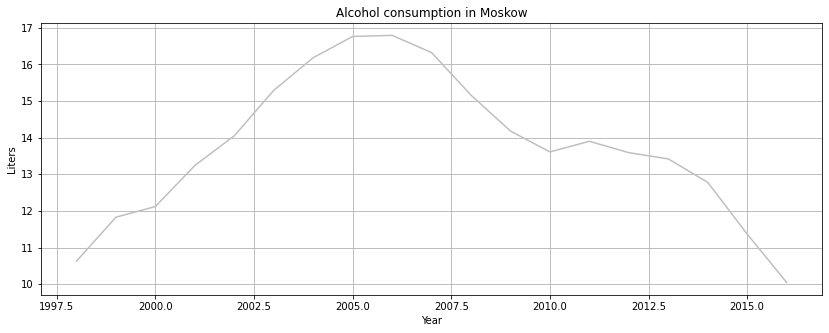

In [4]:
fig = plt.figure(figsize=(14,5))
plt.grid(True)
plt.grid
plt.plot(data_years,data_values,color='0.75')
plt.xlabel('Year')
plt.ylabel('Liters')
plt.title('Alcohol consumption in Moskow')

It is clear from the data that alcohol consumption is decreasing over the years with a peak around 2006.\

The question is, if this trend is related to some phenomena and can be linked to i.e. GDP or is it more or less random.

To find this out, two models were chosen for analysis:\
1. normal: *value = normal($\mu$,$\sigma$)*
2. quadratic regression: *value = normal($\beta$·gdp+$\beta$ _2·gdp^2+$\alpha$,$\sigma$)*

The first model uses normal distribution, parameters are $\mu$ - the average value, and the $\sigma$ - the varaince of values. \
 The use of the normal model means that the outcome value is not linked to any porcess and it is simply a randnom value within a specific range.\
For example, given your previous year alcohol consumption, it is rather unlikely that it affects how much you drink this year.

The second model also uses normal distribution, but in place of $\mu$, quadratic polynomial is included. Depending on gdp and $\beta$ values, the \
average value of normal distributoin will move. with the model with quadratic equation we assuem that the consumption increases as the gdp increases, \
but when the sociaty is becoming wealthy, it spends its money on things other than alcohol. The second degree of polynomial was chosen because the \
linear regression tested before did not fit to data.

### Normal model
For our model some prior had to be chosen. As we do not know what are typical values for alcohol consumption we had\
to pick priors by trial.

Assuming that: 
1. a beer(500ml) contains 22,5 ml of alcohol
2. a glass of wine (175ml) contains 21 ml of alcohol
3. a glass of vodka (50ml) contains 20 ml of alcohol

Lets imagine a normal peroson that drinks beer five times a week, and two times a week wine to dinner. That gives us 116,5 ml\
of alcohol per week. In addition lets assume that the same person once a month goes to party and drinks 10 shots of vodka.\
It gives us around 11 liters of alcohol per year. As we know we are calcualting valeus for people in Russia, so lets add additional\
1,5 litre to out value.

We also have to think that some people might go to party twice a month and some will go to one every two month or more rarely.\
So lets set our value is in the range of plus or minus 2,5 liters. Taking all of this into consideration we end up with mean value \
of 12,5 and variance for mean of 2,5.

The sigma value was set to 0,6.  About 90% of the values are within plus or minus 1 liter of the average value

In [5]:
with open('normal_pre.stan','r') as file:
    print(file.read())

generated quantities {
   real mu = normal_rng(12.5,2.5);
   real sigma = fabs(normal_rng(0,0.6));
   real alcohol =  normal_rng(mu, sigma);
}


In [6]:
model_normal = CmdStanModel(stan_file='normal_pre.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [7]:
samp_model1 = model_normal.sample(iter_sampling=1000, iter_warmup=0, chains=1, fixed_param=True, seed=22042020,refresh=1000)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [8]:
mu_sim=samp_model1.stan_variable('mu')
sigma_sim=samp_model1.stan_variable('sigma')
alcohol=samp_model1.stan_variable('alcohol')
az.summary(samp_model1,var_names=['mu','sigma'],round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu,12.54,2.51,7.88,17.27
sigma,0.48,0.34,0.00,1.10


Having generated samples from prior model we can print them alongside with out data, to see weather we choose\
good parameters for values. On the chart below generated samples are compared to real data (red dots)\
From the plot we can assume that the prior was chosen properly and we can go to next step of analysis.

Text(0.5, 1.0, '$\\sigma$')

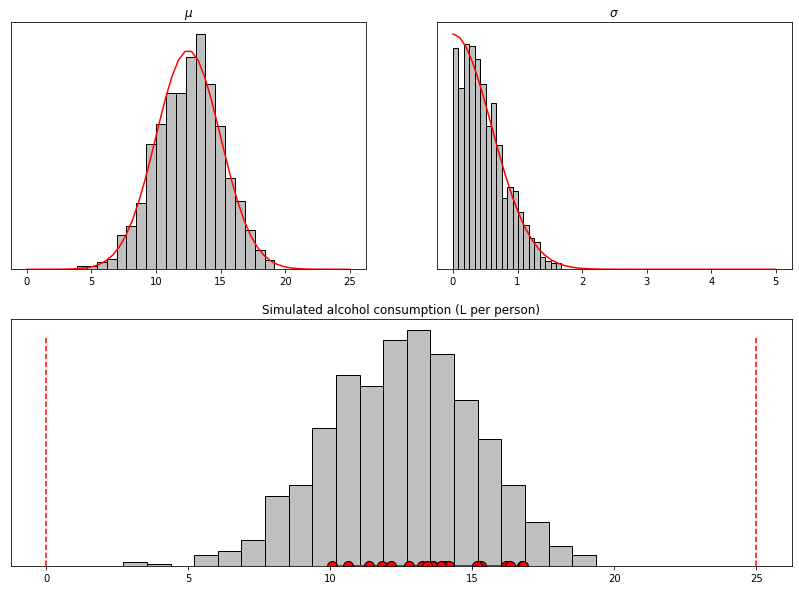

In [9]:
fig = plt.figure(figsize=(14,10))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[1, :])
ax1.hist(alcohol,bins=20,color='0.75',edgecolor='k',density=True)
ax1.vlines([0,25],ymin=0,ymax=15e-2,linestyle='--',color='r',zorder=1)
ax1.set_yticks([])
ax1.set_title('Simulated alcohol consumption (L per person)')
ax1.plot(data_values,zeros,color='r',markeredgecolor='k',markersize=20,marker='.',zorder=2,label='Data')

ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax2.set_yticks([])
ax2.hist(mu_sim,bins=20,color='0.75',edgecolor='k',density=True)
x=np.linspace(0,25)
y=stats.norm.pdf(x,loc=12.5,scale=2.5)
ax2.plot(x,y,'r')
ax2.set_title('$\mu$')
ax2.set_yticks([])
ax3.set_yticks([])

ax3.hist(sigma_sim,bins=20,color='0.75',edgecolor='k',density=True)
x=np.linspace(0,5)
y=stats.halfnorm.pdf(x,loc=0,scale=0.6)
ax3.plot(x,y,'r')
ax3.set_title('$\sigma$')


### POSTERIOR - normal model

In [10]:
fit_normal = CmdStanModel(stan_file='normal_post.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [11]:
with open('normal_post.stan','r') as file:
    print(file.read())

data {
    int N;
    real alcohol_val[N];
}
parameters {
    real<lower=0> mu;
    real<lower=0> sigma;
}

model {
    mu ~ normal(12.5,2.5);
    sigma ~ normal(0,0.6);
    alcohol_val[N] ~ normal(mu,sigma); 
    for(i in 1:N)
    target += normal_lpdf(alcohol_val[i] | mu, sigma);
}
generated quantities {
    real alcohol[N];
    vector[N] log_lik;
    for (i in 1:N){
    alcohol[i] =  normal_rng(mu, sigma);
    log_lik[i] =  normal_lpdf(alcohol_val[i]| mu, sigma);
}}


In [45]:
data = dict(N=len(data_years), alcohol_val=data_values,)

samp_model2 = fit_normal.sample(data=data,seed=29042020)
mu_sim=samp_model2.stan_variable('mu')
sigma_sim=samp_model2.stan_variable('sigma')
alcohol_sim=samp_model2.stan_variable('alcohol')
alcohol_sim_df=pd.DataFrame(samp_model2.stan_variable('alcohol'))

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


Sampling data from model preceeds fast and witout any problems

In [46]:
samp_model2.diagnose()

'Processing csv files: C:\\Users\\mjszo\\AppData\\Local\\Temp\\tmp539gsvbz\\normal_post-20220620195755_1.csv, C:\\Users\\mjszo\\AppData\\Local\\Temp\\tmp539gsvbz\\normal_post-20220620195755_2.csv, C:\\Users\\mjszo\\AppData\\Local\\Temp\\tmp539gsvbz\\normal_post-20220620195755_3.csv, C:\\Users\\mjszo\\AppData\\Local\\Temp\\tmp539gsvbz\\normal_post-20220620195755_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

Diagnose function was has been called. The output of this test, points that model and parameters were chosen properly.\
No divergences occures during samplig, the size of effective samples are good and the R-hat values are satisfactory for all parameter

[]

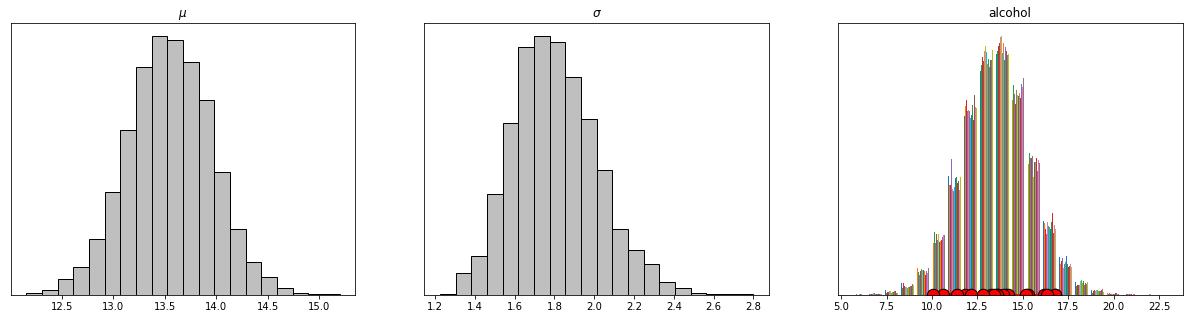

In [53]:
fig = plt.figure(figsize=(21,5))
gs = fig.add_gridspec(1,3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

ax1.hist(mu_sim,bins=20,color='0.75',edgecolor='k',density=True)
ax1.set_title('$\mu$')
ax1.set_yticks([])

ax2.hist(sigma_sim,bins=20,color='0.75',edgecolor='k',density=True)
ax2.set_title('$\sigma$')
ax2.set_yticks([])

ax3.hist(alcohol_sim_df,bins=20,density=True)
ax3.plot(data_values,zeros,color='r',markeredgecolor='k',markersize=25,marker='.',zorder=2,label='Data')
ax3.set_title('alcohol')
ax3.set_yticks([])

After the model was fitted with actual data the distribution of parameters slightly changed. The values of mu lie in range from around 12 to 15, while prior mu \
range was wider (from around 5 to 19). The values of sigma changed as well as the shape of distribution. It might corresponds to fact that values vary more then expected.
For both parameters it can be said that distribution are concentrated and look credibly.

On chart titled 'alcohol' generated samples are compared to actual values (red dots on x-axis). It seems that the model is most propable to generate sample from range 12 to 15
data set range

In [15]:
df=samp_model2.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,alcohol[1],...,log_lik[10],log_lik[11],log_lik[12],log_lik[13],log_lik[14],log_lik[15],log_lik[16],log_lik[17],log_lik[18],log_lik[19]
0,-44.2736,1.000000,0.881645,2.0,3.0,0.0,44.7093,13.4906,1.98578,15.0408,...,-2.62005,-1.95834,-1.66522,-1.60676,-1.62621,-1.60620,-1.60558,-1.66897,-2.17512,-3.10590
1,-45.3979,0.898533,0.881645,2.0,3.0,0.0,45.8031,12.9640,2.04997,13.2004,...,-2.97682,-2.21055,-1.81270,-1.68642,-1.74101,-1.68339,-1.66151,-1.64079,-1.93907,-2.64706
2,-45.7694,0.988626,0.881645,2.0,3.0,0.0,45.9421,12.7908,1.98759,13.4727,...,-3.18224,-2.31627,-1.85011,-1.69079,-1.76157,-1.68670,-1.65597,-1.60588,-1.86137,-2.55664
3,-45.8233,0.912742,0.881645,2.0,3.0,0.0,47.3030,13.4276,2.24910,13.2384,...,-2.55637,-2.02611,-1.78542,-1.73276,-1.75152,-1.73208,-1.72948,-1.77093,-2.14797,-2.85713
4,-44.3392,0.783335,0.881645,1.0,3.0,0.0,49.4975,13.6860,1.56404,13.1139,...,-2.78427,-1.81028,-1.41608,-1.36739,-1.37557,-1.36810,-1.38068,-1.53400,-2.46260,-4.06849


In [16]:
az.summary(samp_model2,var_names=['mu','sigma','alcohol'],round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu,13.55,0.41,12.78,14.30
sigma,1.81,0.21,1.44,2.24
alcohol[0],13.55,1.94,10.07,17.35
alcohol[1],13.58,1.85,10.27,17.32
alcohol[2],13.55,1.83,10.15,17.02
alcohol[3],13.53,1.87,10.23,17.27
alcohol[4],13.54,1.86,10.26,17.17
alcohol[5],13.55,1.89,10.11,17.14
alcohol[6],13.52,1.86,10.04,16.96
alcohol[7],13.55,1.86,9.94,16.95


Using our model we can try to predict average alcohol consumption for following year and compare it to external data for 2017, that is 11.19 litre pre person.\
As you can see below, our model overestimated the value for more than 2 liters, which is not a good result. The good news is that the predicted value is within the confidence interval.

In [17]:
median_alcohol = np.median(alcohol_sim.flatten())
cinf_alcohol_sim = az.hdi(alcohol_sim.flatten(),0.90)
print('Median fo predicted consumption =', median_alcohol)
print('Confidence interval (90%) = [',*cinf_alcohol_sim,']' )

Median fo predicted consumption = 13.554549999999999
Confidence interval (90%) = [ 10.4727 16.6059 ]


To graphically represent the results, the plot_posterior function from the arviz library was used

p:\Users\mjszo\anaconda3\envs\data\lib\site-packages\arviz\data\base.py:216: UserWarning: More chains (4000) than draws (19). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
p:\Users\mjszo\anaconda3\envs\data\lib\site-packages\arviz\data\base.py:216: UserWarning: More chains (4000) than draws (19). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


[]

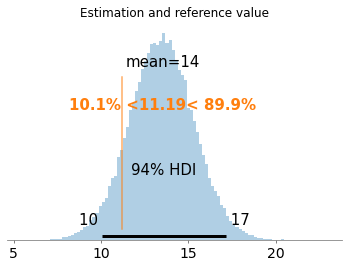

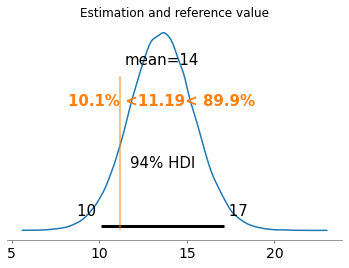

In [18]:
ax1 = az.plot_posterior(alcohol_sim,round_to=2,kind='hist', bins=100,ref_val=DATA_2017)
ax1.set_title('Estimation and reference value')
ax1.set_yticks([])
ax1.set_yticks([])
ax2 = az.plot_posterior(alcohol_sim,round_to=2,kind='kde', bins=100,ref_val=DATA_2017)
ax2.set_title('Estimation and reference value')
ax2.set_yticks([])
ax2.set_yticks([])

### Quadratic regression model

The next model used for our project is model quadratic regression model

Text(0.5, 1.0, 'GDP [$]')

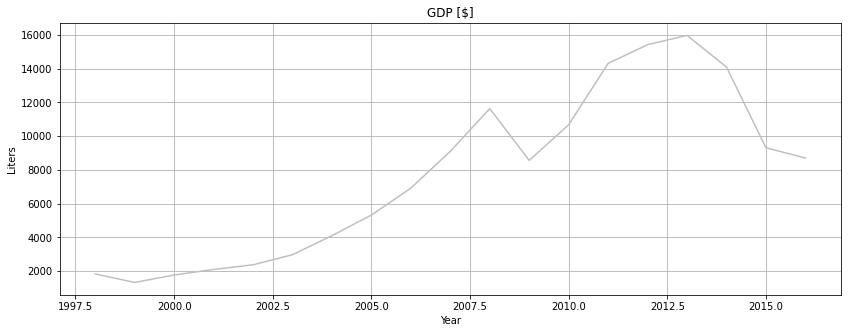

In [59]:
fig = plt.figure(figsize=(14,5))
plt.grid(True)
plt.grid
plt.plot(data_years,data_gdp,color='0.75')
plt.xlabel('Year')
plt.ylabel('Liters')
plt.title('GDP [$]')


In [20]:
with open('regre_pre.stan','r') as file:
    print(file.read())

data {
    int N;
    real gdp[N];
}

generated quantities {
   real alpha = normal_rng(12.5,2.5);
   real beta = fabs(normal_rng(0,1.1));
   real beta2 = -fabs(normal_rng(0,1.3));
   real sigma = fabs(normal_rng(0,0.6));
   real alcohol[N];
   for (i in 1:N){
   alcohol[i] =  normal_rng(gdp[i]*beta+gdp[i]^2*beta2+alpha, sigma);
}}



Parameters of sigma and alpha corresponds to the first model's values of sigma and mu. The values of both beta were chosen experimentaly to fit data. \
An additional "minus" sign was added for the beta2 semi-normal distribution. We want the coefficient "a" of the quadratic equation to be negative and \
the function to have its maximum

In [21]:
model_regre = CmdStanModel(stan_file='regre_pre.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


Some data standarization

In [22]:
c_gdp=data_gdp-data_gdp.mean()
s_gdp=c_gdp/data_gdp.std()

In [23]:
data_ppc={'N':50, 'gdp':np.linspace(-2,2)}
samp_model3 = model_regre.sample(data=data_ppc,iter_sampling=1000, iter_warmup=0, chains=1, fixed_param=True, seed=22042020,refresh=1000)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [24]:
alpha_sim=samp_model3.stan_variable('alpha')
beta_sim=samp_model3.stan_variable('beta')
beta2_sim=samp_model3.stan_variable('beta2')
sigma_sim=samp_model3.stan_variable('sigma')
alcohol=samp_model3.stan_variable('alcohol')


The points reprezenting alcohol consumption as a function of GPD was plotted alongside samples generated from prior model. As can it be\
seen quadratic model is better then liner one and in some way fits the data. ( excluding data corresponding to the financial crisis around 2008 )

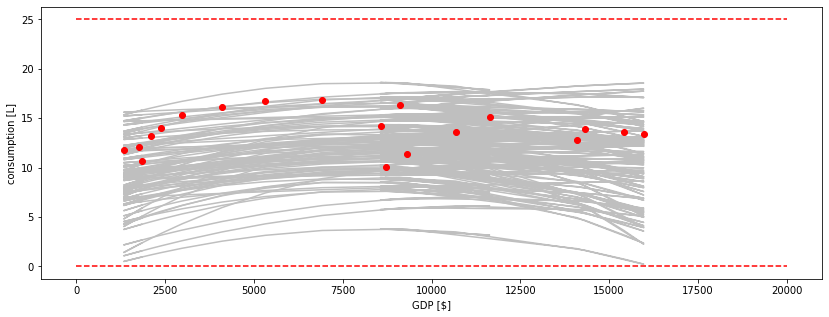

In [25]:
fig, axes = plt.subplots(1,1,figsize=(14,5))
axes.hlines([0,25],xmin=0,xmax=20000,linestyle='--',color='r')
for i in range(100):
    axes.plot(data_gdp,alpha_sim[i]+beta_sim[i]*s_gdp+beta2_sim[i]*s_gdp*s_gdp,c='0.75')
axes.set_ylabel('consumption [L]')
axes.set_xlabel('GDP [$]')
plt.scatter(data_gdp,data_values,zorder=10,c='r')

The prepared model does not fully match the data but overall trend can be seen.

C:\Users\mjszo\AppData\Local\Temp\ipykernel_5092\4277549693.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


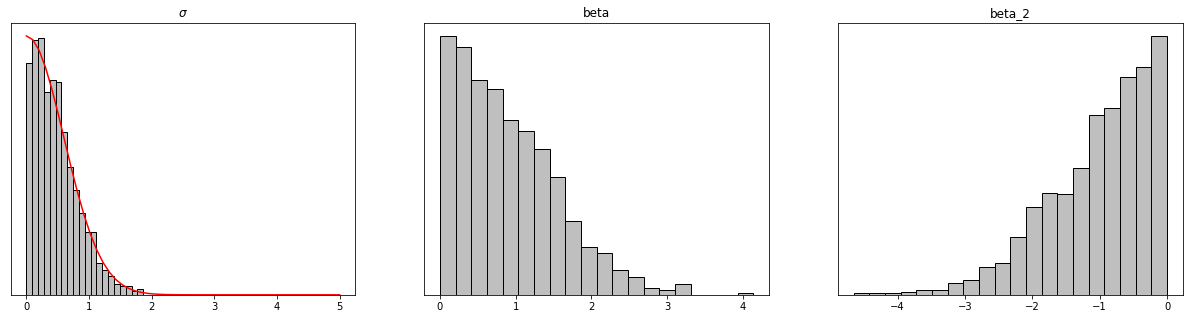

In [26]:
fig = plt.figure(figsize=(21,5))
gs = fig.add_gridspec(1,3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

ax1.hist(sigma_sim,bins=20,color='0.75',edgecolor='k',density=True)
x=np.linspace(0,5)
y=stats.halfnorm.pdf(x,loc=0,scale=0.6)
ax1.plot(x,y,'r')
ax1.set_title('$\sigma$')
ax1.set_yticks([])

ax2.hist(beta_sim,bins=20,color='0.75',edgecolor='k',density=True)
ax2.set_title('beta')
ax2.set_yticks([])

ax3.hist(beta2_sim,bins=20,color='0.75',edgecolor='k',density=True)
ax3.set_title('beta_2')
ax3.set_yticks([])


fig.show()

### POSTERIOR - quadratic model

In [27]:
with open('regre_post.stan','r') as file:
    print(file.read())

data {
    int N;
    real gdp[N];
    real alcohol_val[N];
}
parameters{
    real alpha;
    real<lower=0> beta;
    real<upper=0> beta2;
    real<lower=0> sigma;
}

transformed parameters {
   vector[N] mu;
   for (i in 1:N){
    mu[i]=gdp[i]*beta+gdp[i]*gdp[i]*beta2+alpha;
   }
}

model{
    alpha ~ normal(12.5,2.5);
    beta ~ normal(0,1.1);
    beta2 ~ normal(0,1.3);
    sigma ~ normal(0,0.6);
    for (i in 1:N){
    alcohol_val[i] ~ normal(mu[i],sigma); 
}}

generated quantities {
   real alcohol[N];
   real log_lik[N];
   for (i in 1:N){
    alcohol[i] =  normal_rng(mu[i], sigma);
    log_lik[i] =  normal_lpdf(alcohol_val[i]| mu[i], sigma);
}
}


In [28]:
fit_regre = CmdStanModel(stan_file='regre_post.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [54]:
data = dict(N=len(data_years), gdp=s_gdp, alcohol_val=data_values)
samp_model4 = fit_regre.sample(data=data,seed=29042020)
alpha_sim=samp_model4.stan_variable('alpha')
mu_sim=samp_model4.stan_variable('mu')
mu_sim_df=pd.DataFrame(samp_model4.stan_variable('mu'))
beta_sim=samp_model4.stan_variable('beta')
beta2_sim=samp_model4.stan_variable('beta2')
sigma_sim=samp_model4.stan_variable('sigma')
alcohol_sim=samp_model4.stan_variable('alcohol')
alcohol_sim_df=pd.DataFrame(samp_model4.stan_variable('alcohol'))

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


Sampling data from model preceeds fast and witout any problems

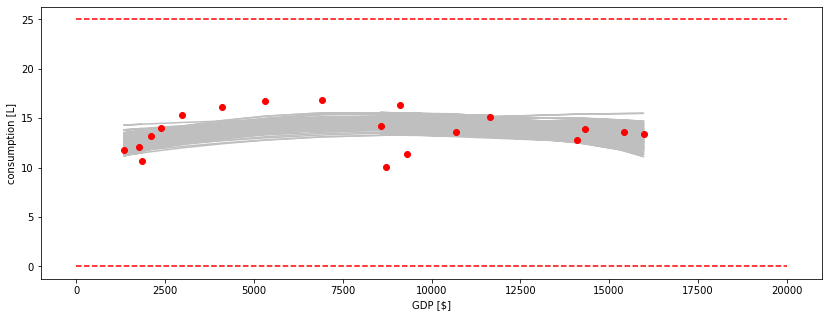

In [55]:
fig, axes = plt.subplots(1,1,figsize=(14,5))
axes.hlines([0,25],xmin=0,xmax=20000,linestyle='--',color='r')
for i in range(100):
    axes.plot(data_gdp,alpha_sim[i]+beta_sim[i]*s_gdp+beta2_sim[i]*s_gdp*s_gdp,c='0.75')
axes.set_ylabel('consumption [L]')
axes.set_xlabel('GDP [$]')
plt.scatter(data_gdp,data_values,zorder=10,c='r')

The range for posterior data significantly narrowed in camparison to prior sampling

In [56]:
samp_model4.diagnose()

'Processing csv files: C:\\Users\\mjszo\\AppData\\Local\\Temp\\tmp539gsvbz\\regre_post-20220620195958_1.csv, C:\\Users\\mjszo\\AppData\\Local\\Temp\\tmp539gsvbz\\regre_post-20220620195958_2.csv, C:\\Users\\mjszo\\AppData\\Local\\Temp\\tmp539gsvbz\\regre_post-20220620195958_3.csv, C:\\Users\\mjszo\\AppData\\Local\\Temp\\tmp539gsvbz\\regre_post-20220620195958_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

Diagnose function was has been called. The output of this test points, that model and parameters were chosen properly.\
No divergences occures during samplig, the size of effective samples are good and the R-hat values are satisfactory for all parameters

[]

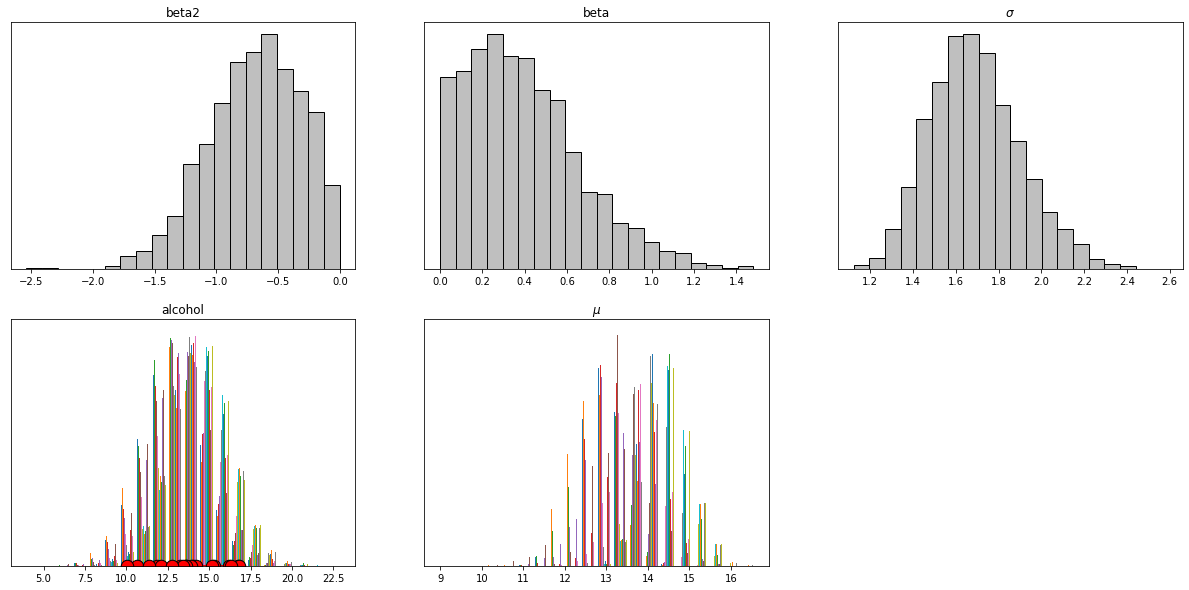

In [63]:
fig = plt.figure(figsize=(21,10))
gs = fig.add_gridspec(2,3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])

ax1.hist(beta2_sim,bins=20,color='0.75',edgecolor='k',density=True)
ax1.set_title('beta2')
ax1.set_yticks([])

ax2.hist(beta_sim,bins=20,color='0.75',edgecolor='k',density=True)
ax2.set_title('beta')
ax2.set_yticks([])

ax3.hist(sigma_sim,bins=20,color='0.75',edgecolor='k',density=True)
ax3.set_title('$\sigma$')
ax3.set_yticks([])

ax4.hist(alcohol_sim_df,bins=20,density=True)
ax4.plot(data_values,zeros,color='r',markeredgecolor='k',markersize=25,marker='.',zorder=2,label='Data')
ax4.set_title('alcohol')
ax4.set_yticks([])

ax5.hist(mu_sim_df,bins=20,density=True)
ax5.set_title('$\mu$')
ax5.set_yticks([])


After the model was fitted with actual data the distribution of parameters slightly changed. Like previous the shape and values of sigma changed in comparison to prior parameter \
The range of values of beta and beta2 narrowed in both cases (2 times for beta2 and 3 times for beta). The shape of both distributions look quite similar to half normal distribution \
bot with moved mean.

On chart titled 'alcohol' generated samples are compared to actual values (red dots on x-axis). It looks like the model is more likely to generate values that are in the middle of \
data set range

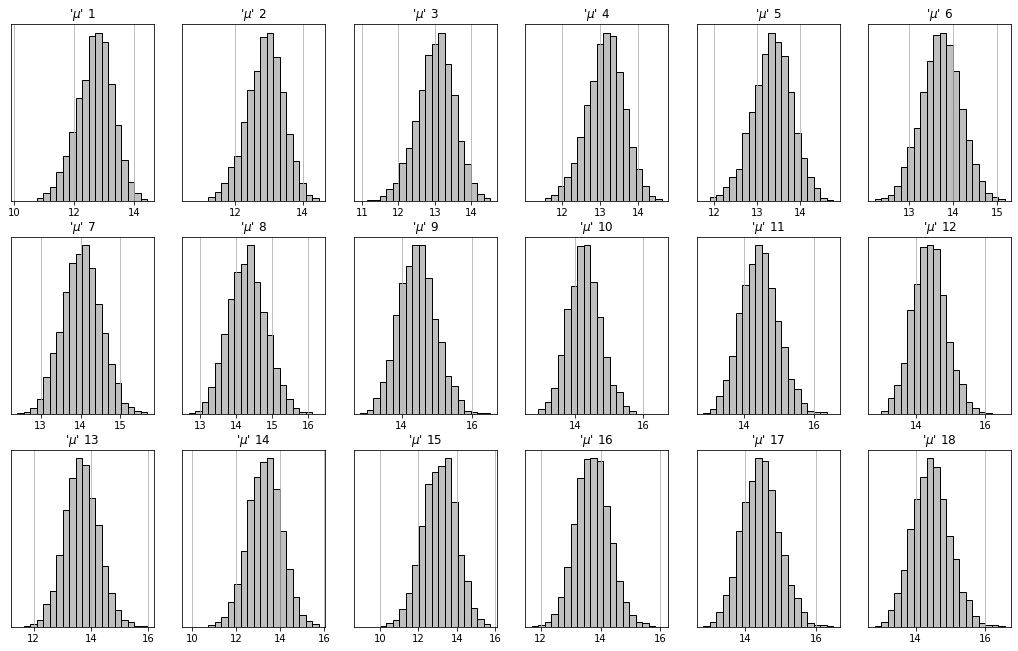

In [33]:
fig = plt.figure(figsize=(21,15))
gs = fig.add_gridspec(4,7)
ax=[18]

for j in range(0,3):
    for i in range(0,6):
        ax.append(fig.add_subplot(gs[j, i]))

m=1
for j in range(0,3):
    for i in range(0,6):
            ax[m].hist(mu_sim_df[m],color='0.75',edgecolor='k',bins=20,density=True)
            ax[m].set_title(f"'$\mu$' {m}")
            ax[m].set_yticks([])
            ax[m].grid()
            m=m+1

The parameters of the posterior model are concentrated, as can be seen in the histograms of these parameters. Depending on actual GDP the mean slightly differs.

In [34]:
df=samp_model4.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,beta2,...,log_lik[10],log_lik[11],log_lik[12],log_lik[13],log_lik[14],log_lik[15],log_lik[16],log_lik[17],log_lik[18],log_lik[19]
0,-27.5682,0.987629,0.24658,3.0,15.0,0.0,28.6963,13.9169,0.576382,-0.671262,...,-2.43389,-1.66940,-1.37958,-1.40669,-1.40961,-1.41041,-1.41268,-1.48508,-2.80399,-4.53003
1,-32.9704,0.694453,0.24658,3.0,7.0,0.0,35.6122,13.2021,0.548457,-0.568871,...,-3.47634,-2.14171,-1.47678,-1.29994,-1.51974,-1.49307,-1.48325,-1.28726,-2.20386,-3.82816
2,-34.3717,0.867192,0.24658,2.0,3.0,0.0,34.9635,13.2262,0.541847,-0.755630,...,-3.46971,-2.23789,-1.46859,-1.30612,-1.70168,-1.74672,-1.77959,-1.28351,-2.20666,-3.85661
3,-31.8030,0.698360,0.24658,3.0,11.0,0.0,36.5402,13.5493,0.461427,-0.827754,...,-3.08634,-2.04919,-1.35154,-1.27118,-1.64745,-1.73436,-1.79293,-1.26976,-2.51598,-4.41133
4,-28.7937,0.442640,0.24658,2.0,3.0,0.0,35.1194,13.9479,0.678093,-0.216703,...,-2.33085,-1.51709,-1.39277,-1.47719,-1.45287,-1.54374,-1.60688,-1.94253,-2.89269,-4.55033


In [35]:
az.summary(samp_model4,var_names=['mu','sigma','alcohol'],round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu[0],12.91,0.54,11.84,13.87
mu[1],12.69,0.60,11.52,13.79
mu[2],12.88,0.55,11.81,13.86
mu[3],13.02,0.51,12.03,13.96
mu[4],13.13,0.49,12.25,14.12
mu[5],13.35,0.46,12.47,14.20
mu[6],13.72,0.45,12.83,14.51
mu[7],14.03,0.48,13.15,14.94
mu[8],14.30,0.52,13.30,15.26
mu[9],14.44,0.53,13.48,15.47


Using our model we can try to predict average alcohol consumption for following year and compare it to external data for 2017, that is 11.19 litre pre person.\
Surprisingly the output of the model with regression is almost the same as the output of normal model with slighly wider confidence interval. It might mean that\
there is no relation between GDP and alcohol conusmption.

In [36]:
median_alcohol = np.median(alcohol_sim)
cinf_alcohol_sim = az.hdi(alcohol_sim.flatten(),0.89)
print('Median fo predicted consumption =', median_alcohol)
print('Confidence interval = [',*cinf_alcohol_sim,']' )
print(DATA_2017)

Median fo predicted consumption = 13.70305
Confidence interval = [ 10.7379 16.7974 ]
11.19


p:\Users\mjszo\anaconda3\envs\data\lib\site-packages\arviz\data\base.py:216: UserWarning: More chains (4000) than draws (19). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
p:\Users\mjszo\anaconda3\envs\data\lib\site-packages\arviz\data\base.py:216: UserWarning: More chains (4000) than draws (19). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


<AxesSubplot:title={'center':'x'}>

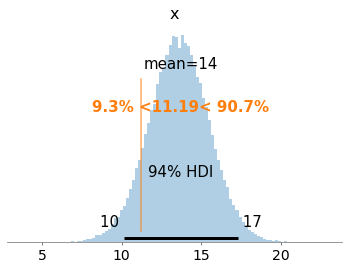

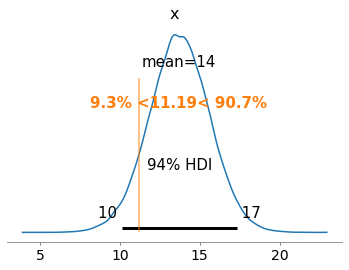

In [36]:
az.plot_posterior(alcohol_sim,round_to=2,kind='hist', bins=100,ref_val=DATA_2017)
az.plot_posterior(alcohol_sim,round_to=2,kind='kde', bins=100,ref_val=DATA_2017)

### Model comparison

In [37]:
fit_n=az.from_cmdstanpy(posterior=samp_model2, posterior_predictive='alcohol',log_likelihood='log_lik')
fit_r=az.from_cmdstanpy(posterior=samp_model4, posterior_predictive='alcohol',log_likelihood='log_lik')

In [38]:
loo_compare = az.compare({'Normal':fit_n,'Regression':fit_r}, 'loo')
loo_compare

p:\Users\mjszo\anaconda3\envs\data\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
p:\Users\mjszo\anaconda3\envs\data\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Normal,0,-41.622382,1.691984,0.000000,0.513639,3.071663,0.000000,False,log
Regression,1,-42.353919,3.388454,0.731537,0.486361,4.525692,2.758255,False,log


The output of LOO criterion shows that the Normal model was better but differences are not that significant. The LOO value for this model is higher \
as well as weight. For none of model any error appeard 


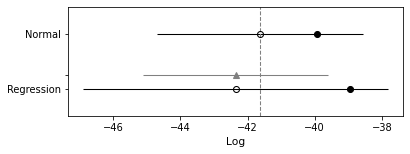

In [40]:
az.plot_compare(loo_compare)
plt.show()


In [39]:
waic_compare = az.compare({'Normal':fit_n,'Regression':fit_r}, 'waic')
waic_compare

p:\Users\mjszo\anaconda3\envs\data\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
p:\Users\mjszo\anaconda3\envs\data\lib\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
p:\Users\mjszo\anaconda3\envs\data\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Normal,0,-41.599617,1.669219,0.000000,0.50678,3.064054,0.000000,False,log
Regression,1,-42.257318,3.291854,0.657701,0.49322,4.469408,2.705743,True,log


The output information from the WAIC criterion is almost the same as for the LOO criterion. The normal model is slightly better, the values \
waic parameter and weights are higher compared to the regression model. In this case, there was a warning for the second model. According to the \
diagnostic message, the output may not be reliable because for some samples the posterior variance of the logarithmic predictive densities exceeds 0.4.

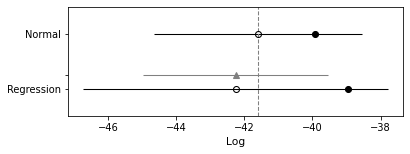

In [41]:
az.plot_compare(waic_compare)
plt.show()

After plotting the results we can see that outputs of loo and waic criteria are quite similar. What is suprising in both cases the normal model slightly\
better describes the analysed data, the line corresponding to that model is shorter. Comparison of models brought us to conclusion that alcohol consumption \
is not corelated with GDP, because there were better results even without additional data. It makes sense, especially in Russia, where drinking alcohol can \
be also taken as “part of culture”, so at many social events or even family meetings it is common stimulant. This conclusion can be used by organization \
making campaigns about reasonable drinking or alcohol companies when planning their advertisement and so on.